## IMDB Linear Regression

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from IPython.display import display
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
sns.set_style("whitegrid")
sns.set_palette("Set2")
%pylab inline

/Users/navina/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
imdb_df_clean = pd.read_csv("imdb_df_clean.csv", sep='\t', index_col=0)
imdb_df_raw = pd.read_csv('imdb_df_raw.csv', sep='\t', index_col=0)

In [3]:
imdb_df_clean = imdb_df_clean.drop('Unnamed: 0.1', axis = 1)

In [4]:
imdb_df_clean.head(2)

,genre,runtime,budget,mpaa_rating,user_rating,total_votes,critic_score,us_boxoffice_gross
0,"Action, Adventure, Sci-Fi",131.0,190000000,PG-13,7.0,409200,64,101800000
1,"Crime, Drama, Mystery",153.0,46000000,R,8.1,453418,74,61000000


### Dropping Outliers

In [5]:
imdb_df_clean = imdb_df_clean[(imdb_df_clean.us_boxoffice_gross < 400000000) & (imdb_df_clean.us_boxoffice_gross > 11000)]
imdb_df_clean = imdb_df_clean[(imdb_df_clean.budget < 250000000) & (imdb_df_clean.budget > 49999)]

In [6]:
imdb_df_clean.shape

(2195, 8)

### Log Transformation

- Applying log transformation on us_boxoffice_gross and budget columns.

- Without transformation, the OLS model did not satisfy the assumptions for linear regression, hence these features are being transformed.

In [7]:
# applying log transformation on us_boxoffice_gross and budget
imdb_df_clean['us_boxoffice_gross'] = np.log(imdb_df_clean['us_boxoffice_gross'])
imdb_df_clean['budget'] = np.log(imdb_df_clean['budget'])

### Correlation matrix

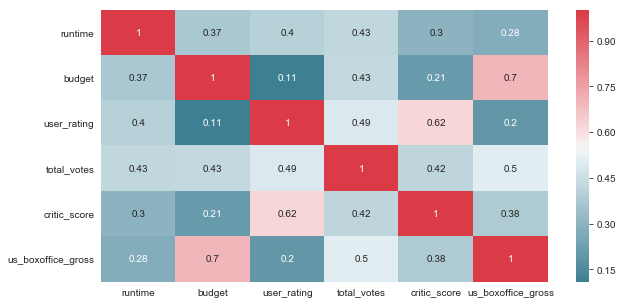

In [8]:
f, ax = plt.subplots(figsize=(10, 5))
corrmat = imdb_df_clean.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corrmat, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# create a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat, cmap = cmap, annot=True)

In [9]:
# correleation between target variable and independent variables
corr = imdb_df_clean.corr()['us_boxoffice_gross']
corr.sort_values(ascending=False)

us_boxoffice_gross    1.000000
budget                0.697955
total_votes           0.503399
critic_score          0.381313
runtime               0.279670
user_rating           0.197860
Name: us_boxoffice_gross, dtype: float64

### One Hot Encoding

In [10]:
# # converting mpaa_rating to dummy variables
# get k-1 dummies out of k categorical levels
mpaa_dummies_df = pd.get_dummies(imdb_df_clean['mpaa_rating'], drop_first=True, prefix='MPAA')
# join repurposed mpaa_rating with main df
imdb_df_clean = imdb_df_clean.join(mpaa_dummies_df)
# drop original mpaa_rating column
imdb_df_clean = imdb_df_clean.drop('mpaa_rating', axis=1)
print("Added %d columns for mpaa_rating" % (mpaa_dummies_df.shape[1]))

Added 3 columns for mpaa_rating


In [11]:
#For multiple genres, create a separate column in DF for each genre
genre_dummies_df = imdb_df_clean['genre'].str.get_dummies(sep=', ')
# join repurposed genre with main df
imdb_df_clean = imdb_df_clean.join(genre_dummies_df)
# drop original genre column
imdb_df_clean = imdb_df_clean.drop('genre', axis=1)
print("Added %d columns for genre"  % (genre_dummies_df.shape[1]))

Added 20 columns for genre


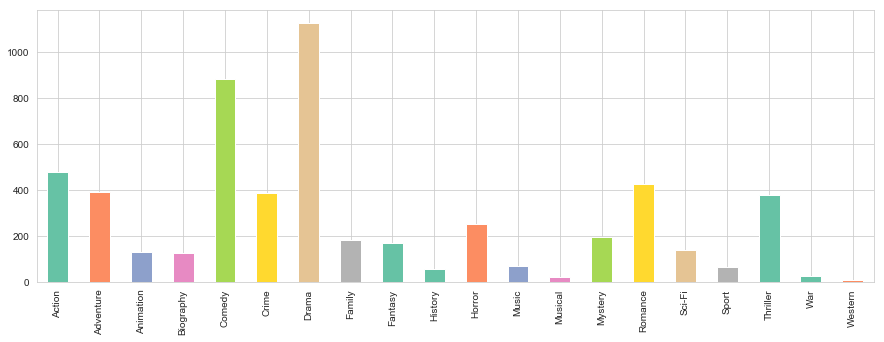

In [12]:
# Box plot genre/us_boxoffice_gross
f, ax = plt.subplots(figsize=(15, 5))
x = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
               'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
               'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
data = pd.DataFrame(imdb_df_clean[x].sum(), columns = ["#movies"])
data["#movies"].plot.bar()
plt.show()

## US Box Office Gross Prediction

#### Creating random training and testing sets of features and labels

In [13]:
# create a Python list of feature names
# Get all columns from dataframe
feature_cols = imdb_df_clean.columns.tolist()
# Filter columns to remove the ones not needed - retain only numeric varaibles
feature_cols  = [c for c in feature_cols if c not in ['us_boxoffice_gross']]
# use the list to select a subset of the original DataFrame
X = imdb_df_clean[feature_cols]
# check type and shape of X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(2195, 28)


In [14]:
# select a Series from the DataFrame
y = imdb_df_clean['us_boxoffice_gross']
# print the first 5 values
y.head()
# check the type and shape of y
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(2195,)


#### Splitting X and y into training and testing sets

In [15]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1646, 28)
(1646,)
(549, 28)
(549,)


/Users/navina/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### OLS Model

In [16]:
# using statsmodels
linreg_model_fit = sm.OLS(y_train, X_train).fit()
linreg_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     us_boxoffice_gross   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5370.
Date:                Sat, 13 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:12:43   Log-Likelihood:                -3168.8
No. Observations:                1646   AIC:                             6394.
Df Residuals:                    1618   BIC:                             6545.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
runtime            0.0027      0.003      0.785      0.432      -0.004       0.010
budget             0.8760      0.028     31.708      0.000       0.822       0.930
user_rating       -0.0499      0.054     -0.917      0.359      -0.156       0.057
total_votes     3.665e-06   3.87e-07      9.474      0.000    2.91e-06    4.42e-06
critic_score       0.0330      0.003     12.503      0.000       0.028       0.038
MPAA_Not Rated    -1.2037      0.343     -3.507      0.000      -1.877      -0.530
MPAA_PG-13         0.2367      0.283      0.835      0.404      -0.319       0.792
MPAA_R            -0.7256      0.293     -2.480      0.013      -1.299      -0.152
Action            -0.0383      0.130     -0.295      0.768      -0.293       0.216
Adventure         -0.2526      0.140     -1.801      0.072      -0.528       0.023
Animation         -0.1172      0.219     -0.536      0.592      -0.547       0.312
Biography          0.0308      0.200      0.154      0.877      -0.361       0.422
Comedy             0.2206      0.122      1.811      0.070      -0.018       0.460
Crime             -0.2378      0.129     -1.842      0.066      -0.491       0.015
Drama             -0.6980      0.120     -5.833      0.000      -0.933      -0.463
Family             0.2254      0.173      1.304      0.192      -0.114       0.565
Fantasy           -0.5615      0.167     -3.365      0.001      -0.889      -0.234
History           -0.3842      0.279     -1.377      0.169      -0.932       0.163
Horror             0.6910      0.160      4.327      0.000       0.378       1.004
Music              0.1406      0.256      0.548      0.584      -0.362       0.643
Musical           -0.2226      0.441     -0.504      0.614      -1.089       0.643
Mystery            0.0734      0.157      0.468      0.640      -0.234       0.381
Romance            0.0720      0.127      0.569      0.569      -0.176       0.320
Sci-Fi            -0.4378      0.189     -2.320      0.020      -0.808      -0.068
Sport              0.1254      0.260      0.482      0.630      -0.385       0.636
Thriller          -0.1338      0.132     -1.016      0.310      -0.392       0.124
War               -0.5956      0.381     -1.565      0.118      -1.342       0.151
Western            0.4780      0.693      0.690      0.490      -0.880       1.836
==============================================================================
Omnibus:                      163.426   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.282
Skew:                          -0.749   Prob(JB):                     1.81e-52
Kurtosis:                       4.110   Cond. No.                     2.86e+06
==============================================================================

Warnings:
[1] Standard Errors assum

#### Evaluation metrics for OLS Full Model

In [17]:
# make predictions on testing set
y_pred_linreg = linreg_model_fit.predict(X_test)

# RMSE for the training set
print("RMSE Train: {}".format(
    sm.tools.eval_measures.rmse(y_train, linreg_model_fit.fittedvalues, axis=0)))

RMSE Train: 1.6589672940990068


In [18]:
# make predictions on testing set
y_pred_linreg = linreg_model_fit.predict(X_test)

In [19]:
# calculate RMSE - MSE "punishes" larger errors
#                - RMSE is interpretable in the "y" units
print("RMSE Test: {}".format(sm.tools.eval_measures.rmse(y_test, y_pred_linreg, axis=0)))

print("")

# # Prediction for first movie in test dataset
# # since us_boxoffice_gross is a log transformation, reverting it back using exp fn
print("Prediction for first three movies in test dataset: {}".format(np.exp(y_pred_linreg.iloc[0:3])))

RMSE Test: 1.6217756822846299

Prediction for first three movies in test dataset: 4121    3.897303e+06
554     5.200025e+06
2229    1.680238e+07
dtype: float64


#### Plotting (OLS Full Model)

In [20]:
# fitted values
linreg_fitted_y = linreg_model_fit.fittedvalues

# model residuals
linreg_residuals = linreg_model_fit.resid

# normalized residuals
linreg_norm_residuals = linreg_model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
linreg_norm_residuals_abs_sqrt = np.sqrt(np.abs(linreg_norm_residuals))

# absolute residuals
linreg_abs_resid = np.abs(linreg_residuals) 

# leverage, from statsmodels internals
linreg_leverage = linreg_model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
linreg_cooks = linreg_model_fit.get_influence().cooks_distance[0]

#### Residual Plot (OLS Full Model)

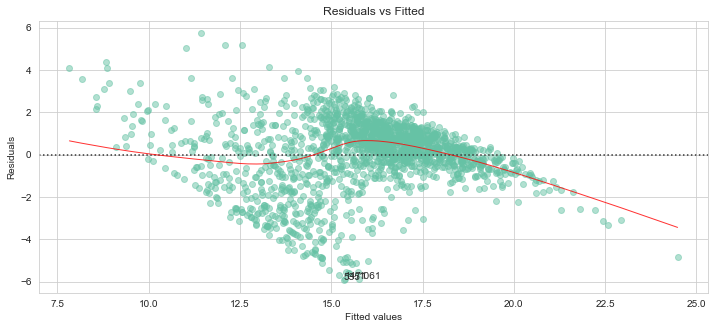

In [21]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(12)
plot_lm_1.axes[0] = sns.residplot(linreg_fitted_y, y_train, data=imdb_df_clean, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = linreg_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]
for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(linreg_fitted_y[i], 
                                   linreg_residuals[i]))


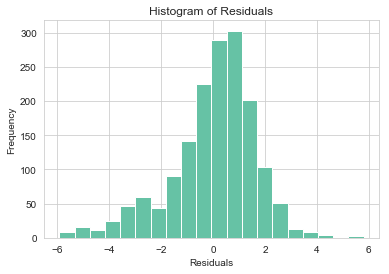

In [22]:
# historgram of residuals
plot_lm_2 = plt.figure(1)
plot_lm_2.axes[0] = linreg_model_fit.resid.hist(bins=20)
plot_lm_2.axes[0].set_title('Histogram of Residuals')
plot_lm_2.axes[0].set_xlabel('Residuals')
plot_lm_2.axes[0].set_ylabel('Frequency')


###### Though the residuals show normality, the pattern in residuals indicate heteroscedasticity. 
Steps that were taken to combat heteroscedasticity:

1) Log transformation of variables

2) Removing outliers

3) Used VIF to weed out multicollinear variables before adding to model

4) Did not try the following: a) Box-Cox Transformation b) Weighted Regression


In [23]:
# from sklearn.linear_model import LinearRegression
# def diagnostic_plot(x, y):
#     plt.figure(figsize=(20,5))
    
#     rgr = LinearRegression()
#     rgr.fit(x.reshape(s,1),y)
#     pred = rgr.predict(x.reshape(s,1))

#     plt.subplot(1, 3, 1)
#     plt.scatter(x,y)
#     plt.plot(x, pred, color='blue',linewidth=1)
#     plt.title("Regression fit")
#     plt.xlabel("x")
#     plt.ylabel("y")
    
#     plt.subplot(1, 3, 2)
#     res = y - pred
#     plt.scatter(pred, res)
#     plt.title("Residual plot")
#     plt.xlabel("prediction")
#     plt.ylabel("residuals")
    
#     plt.subplot(1, 3, 3)
#     #Generates a probability plot of sample data against the quantiles of a 
#     # specified theoretical distribution 
#     stats.probplot(res, dist="norm", plot=plt)
#     plt.title("Normal Q-Q plot")

In [24]:
# # We can diagnose/ inspect our residual normality assumption using qqplot:
# stats.probplot(data['resid'], dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

#### Multicollinearity and Feature Elimination 

In [25]:
# if VIF is between 5-10, multicolinearity is likely present we should consider dropping the variable
# check for VIF, remove variables with VIF > 4
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [26]:
# calculate_vif_(X)

After running the VIF function, variables with a score between 5 and 10 were weeded out before adding to successive OLS models. This continued to show heteroscedasticity despite normal distribution of residuals. Since transformations, checking VIF for multicollinearity and successive removal of features did not improve the heteroscedasticity, a random forest regressor was used.

**Note:** Please refer to 4_imdb_regression_RF for the random forest model